In [1]:
#imports 
import wisps
import splat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [2]:
#constants
sns.set_palette('husl')

fltrswfc3= ['WFC3_{}'.format(k) for k in ['F110W', 'F140W', 'F160W']]

#load spectra
bonafide_spectra=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl')

In [3]:
#functions 
def measure_all_mags(sp):
    mags={}
    for k in fltrswfc3:
        mags.update( measure_mag(sp, k))
        
    return mags
        

def measure_mag(sp, flt):
    #flux calibrate
    sp.trim([1.1, 1.7])
    mag, mag_unc = splat.filterMag(sp, flt)
    return {flt: [mag, mag_unc], 'spectra':sp }

def scale_spectrum(sp):
    med_flux=np.nanmedian(sp.flux.value[np.logical_and(sp.wave.value >=1.2, sp.wave.value<=1.3 )])
    sp.scale(REF_FLUX/med_flux)

    return sp

In [4]:
spectral_types=np.vstack([x.spectral_type for x in bonafide_spectra])

In [5]:
#reference mdwarf
REF_MDWARF=bonafide_spectra[np.logical_and(spectral_types[:,0]==17., spectral_types[:,1]==0.0)][0]
#wavelength range
REF_FLUX= np.nanmedian(REF_MDWARF.flux[np.logical_and(REF_MDWARF.wave >=1.2, REF_MDWARF.wave<=1.3 )])

REF_MAG={}
for k in fltrswfc3:
    REF_MAG.update(measure_mag(REF_MDWARF.splat_spectrum, k))

In [6]:
scaled_spectra= [scale_spectrum(x.splat_spectrum) for x in bonafide_spectra]
scale_mags=[measure_all_mags(xi) for xi in tqdm(scaled_spectra) ]

100%|██████████| 482/482 [02:15<00:00,  3.56it/s]


Text(0, 0.5, 'Flux (normalized)')

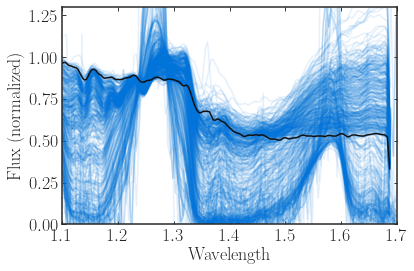

In [7]:
for x in scaled_spectra:
    plt.plot(x.wave, x.flux, alpha=0.1, c='#0074D9')

plt.plot(REF_MDWARF.wave, REF_MDWARF.flux, c='#111111')
plt.xlim([1.1, 1.7])
plt.ylim([0.0, 1.3])
plt.xlabel('Wavelength')
plt.ylabel('Flux (normalized)')

In [8]:
mag_df=pd.DataFrame.from_records(scale_mags)
mag_df['snr1']=[x.snr['snr1'] for x in bonafide_spectra]
mag_df['snr3']=[x.snr['snr3'] for x in bonafide_spectra]
mag_df['medsnr']=[x.snr['snr4'] for x in bonafide_spectra]
mag_df['spt']=[x.spectral_type[0] for x in bonafide_spectra]
mag_df['spt_er']=[x.spectral_type[1] for x in bonafide_spectra]

In [9]:
for k in ['F110W', 'F140W', 'F160W']:
    mgkey='WFC3_{}'.format(k)
    #compute offsets and uncertainties using standard error propagation
    mag_df['rel'+k]= np.vstack(mag_df[mgkey].values)[:,0]-REF_MAG[mgkey][0]
    mag_df['rel'+k+'_er']=((np.vstack(mag_df[mgkey].values)[:,1])**2+(REF_MAG[mgkey][1])**2)**0.5


In [10]:
#delete outliers
mag_df=(mag_df[mag_df.snr1 >1.]).reset_index(drop=True)

In [11]:
YET_ANOTHER_POLYNOMIAL={}

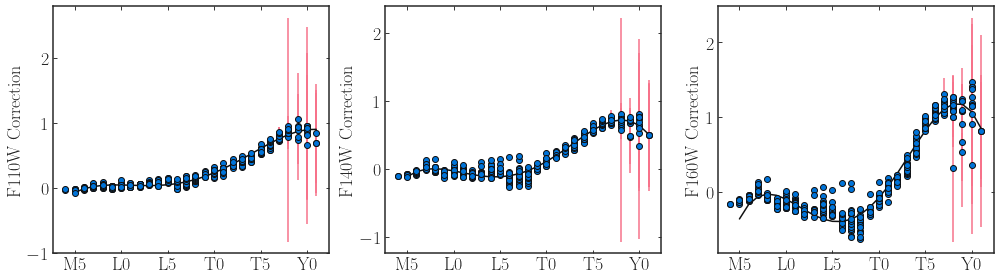

In [29]:
fig, ax=plt.subplots(ncols=3, figsize=(14, 4), sharex=True, sharey=False)

for idx, flt in enumerate(['rel'+k for k in ['F110W', 'F140W', 'F160W']]):
    mask, pol=wisps.fit_with_nsigma_clipping(mag_df.spt.values, mag_df[flt].values, 
                                             mag_df[flt+'_er'].values, n=4, sigma=5)
    ax[idx].errorbar( mag_df.spt, mag_df[flt], yerr=mag_df[flt+'_er'], fmt='o', mec='#111111', mfc='#0074D9', alpha=1.)
    #c=ax[idx].scatter( mag_df.spt, mag_df[flt], c=mag_df.snr1.apply(np.log10), cmap='coolwarm', s=40)
    ax[idx].plot(np.arange(15, 42), pol(np.arange(15, 42)), c='#111111')
    
    xvl=mag_df.spt.values
    yvl=mag_df[flt].values
    
    YET_ANOTHER_POLYNOMIAL.update({flt.replace('rel', ""):(pol, abs(yvl[mask]-pol(xvl[mask])).mean())})
    
    ax[idx].set_xticks([15, 20, 25, 30, 35, 40])
    ax[idx].set_xticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])
    
    ax[idx].set_ylabel('{} Correction'.format(flt.replace('rel', "")))

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_corrections_trimed.pdf',  rasterized=True, bbox_inches='tight')
#plt.ylim([-1, 4])
#plt.xlabel('Spectral Type')
#plt.ylabel('Magnitude offset from standard M7')
#plt.colorbar(c)

In [13]:
 np.shape(scaled_spectra)

(482,)

In [14]:
import splat.photometry as sphot

f140=sphot.filterProfile('WFC3 F140W')
f160=sphot.filterProfile('WFC3 F160W')
f110=sphot.filterProfile('WFC3 F110W')
j_filt=sphot.filterProfile('2MASS J')
h_filt=sphot.filterProfile('2MASS H')

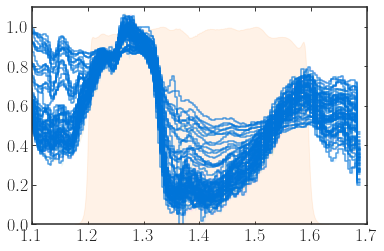

In [15]:
spcs=mag_df[np.logical_and(mag_df.spt.between(17, 35), mag_df.relF160W.between(0.0, 0.5))].spectra.values
fig, ax=plt.subplots()
#2mass
#ax.plot( j_filt[0], j_filt[1]/((j_filt[1]).max()), alpha=1., color='#AAAAAA',linewidth=5)
#ax.plot( h_filt[0], h_filt[1]/((h_filt[1]).max()), alpha=1., color='#AAAAAA',linewidth=5)
ax.fill_between( f140[0], f140[1]*(1/(f140[1]).max()), 0, alpha=0.1, color='#FF851B')
for x in spcs:
    plt.step(x.wave, x.flux, alpha=0.7, c='#0074D9')
    plt.fill_between(x.wave,  x.flux+x.noise, x.flux-x.noise, alpha=0.1, where='mid' )
    plt.xlim([1.1, 1.7])
    plt.ylim([0.0, 1.1])

In [24]:
rels=wisps.POLYNOMIAL_RELATIONS

In [25]:
rels.update({'mag_limit_corrections': YET_ANOTHER_POLYNOMIAL})

In [ ]:
jklasad

In [30]:
#/polynomial_relations.pkl'
import pickle
output = open(wisps.OUTPUT_FILES+'/polynomial_relations.pkl', 'wb')
pickle.dump(rels, output)
output.close()
